# Modelos de predicción para una unidad de urooncología

### 1. Importación de librerías

In [1]:
# Librerias
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

### 2. Cargar los datos

In [2]:
# df = pd.read_excel(r'the_only_excel.xlsx')
engine = sqla.create_engine('mysql://root:@localhost/tfg_bd', echo = False)
query = "SELECT * FROM patients"
df = pd.read_sql(query, engine)        
print(df)

       N   FECHACIR  EDAD  ETNIA  OBESO  HTA  DM  TABACO  HEREDA  TACTOR  ...  \
0      3 2009-09-07    65      1      3    2   2       1       2       1  ...   
1      4 2011-05-18    74      1      2    2   2       2       2       1  ...   
2      5 2009-04-01    70      1      2    1   2       1       2       2  ...   
3      6 2014-09-09    67      1      2    1   2       1       2       1  ...   
4      7 2011-11-21    67      1      1    2   1       1       2       1  ...   
..   ...        ...   ...    ...    ...  ...  ..     ...     ...     ...  ...   
199  202 2015-03-17    56      1      3    2   2       2       2       1  ...   
200  203 2014-09-15    68      1      2    1   2       1       2       2  ...   
201  204 2013-04-02    64      1      3    1   2       2       2       2  ...   
202  205 2009-04-23    59      1      3    1   2       2       2       1  ...   
203  206 2010-05-24    64      1      3    2   2       1       2       2  ...   

     KI-67  SPINK1  C-MYC  

In [3]:
df.columns

Index(['N', 'FECHACIR', 'EDAD', 'ETNIA', 'OBESO', 'HTA', 'DM', 'TABACO',
       'HEREDA', 'TACTOR', 'PSAPRE', 'PSALT', 'TDUPPRE', 'ECOTR', 'NBIOPSIA',
       'HISTO', 'GLEASON1', 'NCILPOS', 'BILAT', 'PORCENT', 'IPERIN', 'ILINF',
       'IVASCU', 'TNM1', 'HISTO2', 'GLEASON2', 'BILAT2', 'LOCALIZ', 'MULTIFOC',
       'VOLUMEN', 'EXTRACAP', 'VVSS', 'IPERIN2', 'ILINF2', 'IVASCU2', 'PINAG',
       'MARGEN', 'TNM2', 'PSAPOS', 'RTPADYU', 'RTPMES', 'RBQ', 'TRBQ', 'T1MTX',
       'FECHAFIN', 'TSEGUI', 'FALLEC', 'TSUPERV', 'PSAFIN', 'CAPRA-S',
       'RA-NUCLEAR', 'RA-ESTROMA', 'PTEN', 'ERG', 'KI-67', 'SPINK1', 'C-MYC',
       'NOTAS', 'IMC', 'ASA', 'GR', 'PNV', 'TH', 'PGG'],
      dtype='object')

In [4]:
# Eliminamos las columnas que sabemos que no influyen en nada en las predicciones

df = df.drop(['N', 'NOTAS', 'FECHACIR', 'FECHAFIN'], axis=1)
df.head()

,EDAD,ETNIA,OBESO,HTA,DM,TABACO,HEREDA,TACTOR,PSAPRE,PSALT,...,ERG,KI-67,SPINK1,C-MYC,IMC,ASA,GR,PNV,TH,PGG
0,65,1,3,2,2,1,2,1,5.46,0.85,...,0.0,0.0,0.0,1.0,31.6,NaN,2,NaN,5,0.0
1,74,1,2,2,2,2,2,1,13.34,NaN,...,0.0,0.0,0.0,1.0,27.4,2.0,2,NaN,7,0.0
2,70,1,2,1,2,1,2,2,6.47,0.10,...,1.0,1.0,0.0,1.0,30.0,2.0,2,NaN,6,0.0
3,67,1,2,1,2,1,2,1,8.99,0.19,...,0.0,1.0,0.0,1.0,28.7,2.0,1,NaN,5,0.0
4,67,1,1,2,1,1,2,1,7.96,0.21,...,1.0,1.0,0.0,1.0,24.3,2.0,2,NaN,4,0.0


### 3. Análisis del conjunto de datos

In [5]:
# Dimensiones del dataset
df.shape

(204, 60)

In [6]:
# Resumen estadístico
df.describe(include="all", datetime_is_numeric=True)

,EDAD,ETNIA,OBESO,HTA,DM,TABACO,HEREDA,TACTOR,PSAPRE,PSALT,...,ERG,KI-67,SPINK1,C-MYC,IMC,ASA,GR,PNV,TH,PGG
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,132.000000,...,36.000000,36.000000,36.000000,36.000000,189.000000,200.000000,204.000000,42.000000,204.000000,204.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,61.926471,1.029412,2.004902,1.632353,1.901961,2.102941,1.862745,1.352941,6.862990,0.225985,...,0.361111,0.611111,0.277778,0.583333,28.392593,1.980000,1.627451,1.500000,5.955882,0.001495
std,6.598215,0.219981,0.784691,0.483351,0.298099,1.233439,0.344963,0.589682,3.510452,0.199434,...,0.487136,0.494413,0.454257,0.500000,3.952046,0.548731,0.679344,0.506061,3.017684,0.017904
min,46.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.890000,0.020000,...,0.000000,0.000000,0.000000,0.000000,19.700000,1.000000,0.000000,1.000000,4.000000,0.000000
25%,57.750000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,4.865000,0.107500,...,0.000000,0.000000,0.000000,0.000000,25.700000,2.000000,1.000000,1.000000,5.000000,0.000000
50%,63.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,5.990000,0.180000,...,0.000000,1.000000,0.000000,1.000000,27.800000,2.000000,2.000000,1.500000,5.000000,0.000000
75%,67.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,7.747500,0.250000,...,1.000000,1.000000,1.000000,1.000000,30.400000,2.000000,2.000000,2.000000,6.000000,0.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 60 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EDAD        204 non-null    int64  
 1   ETNIA       204 non-null    int64  
 2   OBESO       204 non-null    int64  
 3   HTA         204 non-null    int64  
 4   DM          204 non-null    int64  
 5   TABACO      204 non-null    int64  
 6   HEREDA      204 non-null    int64  
 7   TACTOR      204 non-null    int64  
 8   PSAPRE      204 non-null    float64
 9   PSALT       132 non-null    float64
 10  TDUPPRE     104 non-null    float64
 11  ECOTR       204 non-null    int64  
 12  NBIOPSIA    204 non-null    int64  
 13  HISTO       204 non-null    int64  
 14  GLEASON1    204 non-null    int64  
 15  NCILPOS     204 non-null    int64  
 16  BILAT       203 non-null    float64
 17  PORCENT     175 non-null    float64
 18  IPERIN      204 non-null    int64  
 19  ILINF       204 non-null    i

In [8]:
# Eliminar las columnas con valores faltantes (NaN), iguales o mayores al 50%
clean_df = df
deleted_cols = 0
for column in df:
    sum_na_values = df[column].isna().sum()
    if sum_na_values > 0:
        percent = sum_na_values/len(df)
        
        if(percent >= 0.5):
            # print(column, ":", percent)
            clean_df = clean_df.drop([column], axis=1)
            deleted_cols += 1

print("Number of deleted columns:", deleted_cols)
print("Number of columns of the cleaned DF:", len(clean_df.columns))
print(clean_df.columns)
df = clean_df

Number of deleted columns: 13
Number of columns of the cleaned DF: 47
Index(['EDAD', 'ETNIA', 'OBESO', 'HTA', 'DM', 'TABACO', 'HEREDA', 'TACTOR',
       'PSAPRE', 'PSALT', 'TDUPPRE', 'ECOTR', 'NBIOPSIA', 'HISTO', 'GLEASON1',
       'NCILPOS', 'BILAT', 'PORCENT', 'IPERIN', 'ILINF', 'IVASCU', 'TNM1',
       'HISTO2', 'GLEASON2', 'BILAT2', 'LOCALIZ', 'MULTIFOC', 'VOLUMEN',
       'EXTRACAP', 'VVSS', 'IPERIN2', 'ILINF2', 'IVASCU2', 'PINAG', 'MARGEN',
       'TNM2', 'PSAPOS', 'RTPADYU', 'RBQ', 'TSEGUI', 'FALLEC', 'CAPRA-S',
       'IMC', 'ASA', 'GR', 'TH', 'PGG'],
      dtype='object')


In [9]:
clean_df['PORCENT'] = clean_df['PORCENT'] / 100
clean_df['VOLUMEN'] = clean_df['VOLUMEN'] / 100

In [10]:
# Si hay algun campo sin datos, lo rellenamos con la mediana de la columna
for column in clean_df:
    if(clean_df[column].isnull().values.any()):
        median = clean_df[column].median()
        clean_df[column].fillna(median, inplace=True)

In [11]:
clean_df.describe()

,EDAD,ETNIA,OBESO,HTA,DM,TABACO,HEREDA,TACTOR,PSAPRE,PSALT,...,RTPADYU,RBQ,TSEGUI,FALLEC,CAPRA-S,IMC,ASA,GR,TH,PGG
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.00000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,61.926471,1.029412,2.004902,1.632353,1.901961,2.102941,1.862745,1.352941,6.862990,0.209755,...,1.848039,1.970588,59.850200,1.95098,2.813725,28.349020,1.980392,1.627451,5.955882,0.001495
std,6.598215,0.219981,0.784691,0.483351,0.298099,1.233439,0.344963,0.589682,3.510452,0.161716,...,0.359866,0.260952,26.958990,0.21644,2.426173,3.806392,0.543305,0.679344,3.017684,0.017904
min,46.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.890000,0.020000,...,1.000000,1.000000,2.203947,1.00000,0.000000,19.700000,1.000000,0.000000,4.000000,0.000000
25%,57.750000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,4.865000,0.147500,...,2.000000,2.000000,40.370066,2.00000,1.000000,26.000000,2.000000,1.000000,5.000000,0.000000
50%,63.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,5.990000,0.180000,...,2.000000,2.000000,57.680921,2.00000,2.000000,27.800000,2.000000,2.000000,5.000000,0.000000
75%,67.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,7.747500,0.210000,...,2.000000,2.000000,77.343750,2.00000,4.000000,30.100000,2.000000,2.000000,6.000000,0.000000
max,78.000000,3.000000,3.000000,2.000000,2.000000,5.000000,2.000000,3.000000,27.000000,0.990000,...,2.000000,3.000000,118.881579,2.00000,11.000000,46.000000,4.000000,2.000000,32.000000,0.250000


In [12]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EDAD      204 non-null    int64  
 1   ETNIA     204 non-null    int64  
 2   OBESO     204 non-null    int64  
 3   HTA       204 non-null    int64  
 4   DM        204 non-null    int64  
 5   TABACO    204 non-null    int64  
 6   HEREDA    204 non-null    int64  
 7   TACTOR    204 non-null    int64  
 8   PSAPRE    204 non-null    float64
 9   PSALT     204 non-null    float64
 10  TDUPPRE   204 non-null    float64
 11  ECOTR     204 non-null    int64  
 12  NBIOPSIA  204 non-null    int64  
 13  HISTO     204 non-null    int64  
 14  GLEASON1  204 non-null    int64  
 15  NCILPOS   204 non-null    int64  
 16  BILAT     204 non-null    float64
 17  PORCENT   204 non-null    float64
 18  IPERIN    204 non-null    int64  
 19  ILINF     204 non-null    int64  
 20  IVASCU    204 non-null    int64 

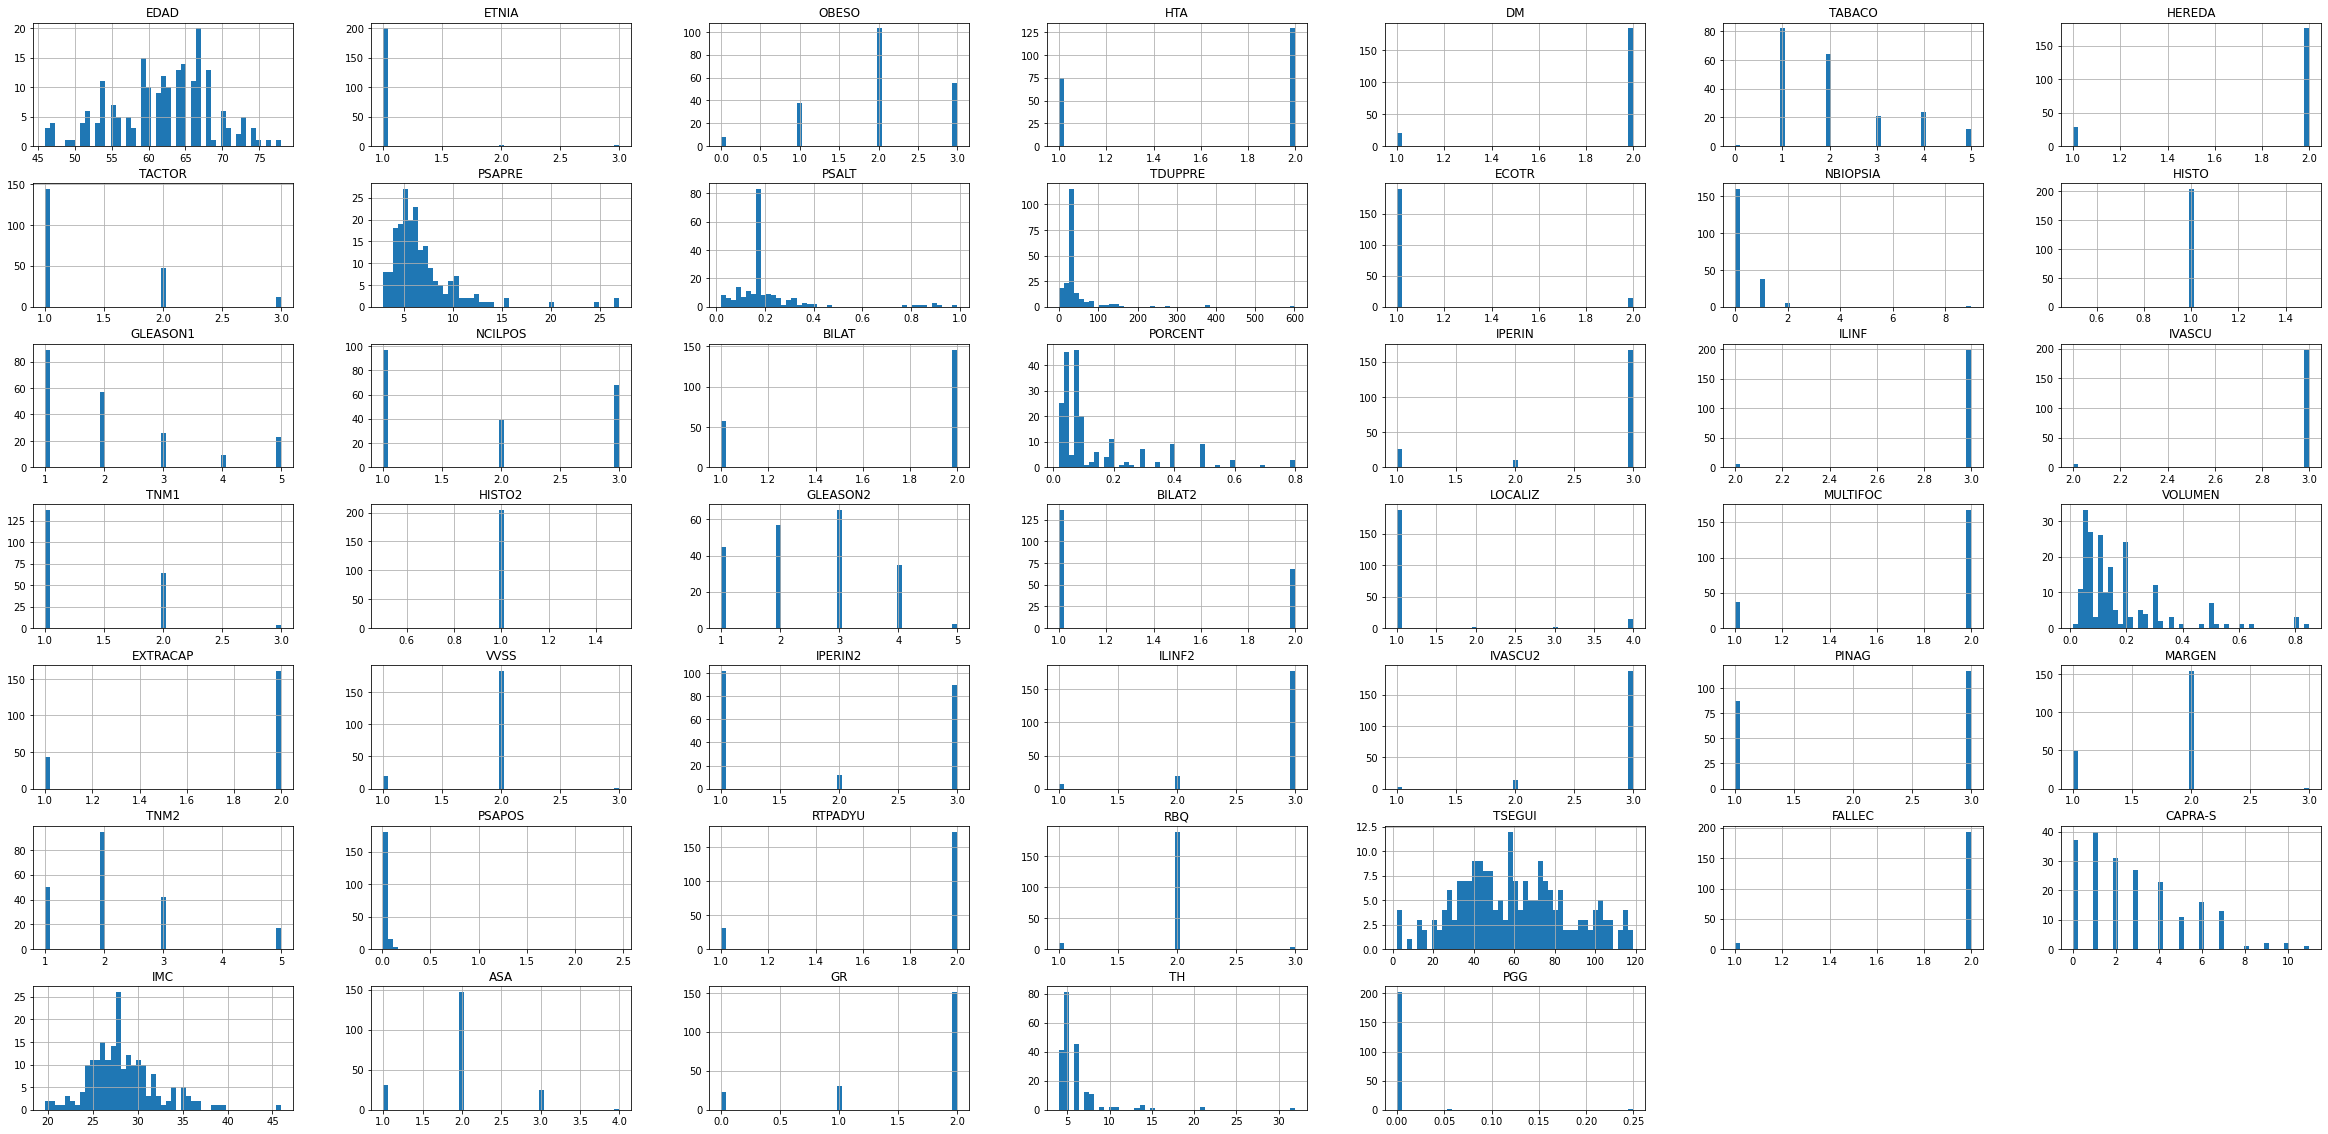

In [13]:
# Histogramas para visualizar los datos
def print_hist():
    clean_df.hist(bins=clean_df.shape[1], figsize=(41,20))
print_hist()

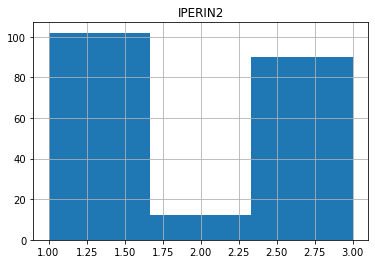

In [14]:
hist = clean_df.hist(column="IPERIN2", bins=3)

In [15]:
# Eliminación de NC (No Conocido)

from random import randrange

for row in clean_df[clean_df["IPERIN2"] == 3].index:
    clean_df.at[row, "IPERIN2"] = randrange(1,3)

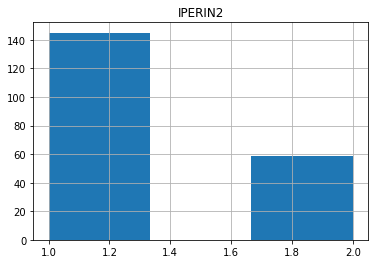

In [16]:
hist = clean_df.hist(column="IPERIN2", bins=3)

In [17]:
# Más drops para realizar el entrenamiento
clean_df = clean_df.drop(['ETNIA', 'HISTO', 'IPERIN', 'ILINF', 'IVASCU', 'HISTO2', 'ILINF2', 'IVASCU2', 'FALLEC'], axis=1)

**Notas**. Columnas eliminadas y motivos:

- ETNIA: Estos estudios se realizaron en España, por lo que la mayoría de la población es caucásica. No aportaría mucha información. Puede producir overfitting si dejamos esta columna. El hecho de ser caucásico influenciaría demasiado sobre la predicción.


- HISTO: Solo hay dos categorías, Adenocarcinoma y Otro. La mayoría pertenece a adenocarcinoma por lo que esta variable no aporta mucha información.


- HISTO2: Igual que HISTO.
    
    
- IPERIN: 3 categorías (si, no, nc). La mayoría de los casos no se conocen. Al tener menos de 30 casos conocidos (sobre los más de 200), no tiene mucho sentido utilizar esta variable.


- ILINF: 3 categorías (si, no, nc). La mayoría de los casos no se conocen. No tiene mucho sentido utilizar esta variable.


- ILINF2: Igual que ILINF


- IVASCU: 3 categorías (si, no, nc). La mayoría de los casos no se conocen. No tiene mucho sentido utilizar esta variable.


- IVASCU2: Igual que IVASCU


- FALLEC: Esta variable se tiene que eliminar, ya que el fallecimiento no influye en nada en la predicción de la RBQ. Además, es una consecuencia, no una causa. Usarlo no tiene ningún sentido.

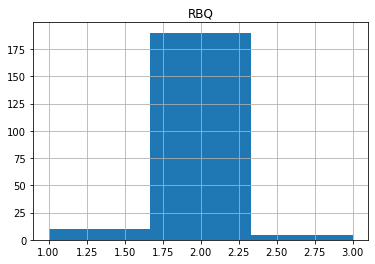

In [18]:
# Gráfico RBQ
hist = clean_df.hist(column="RBQ", bins=3)

In [19]:
# Eliminar aquellos pacientes con PERSISTENCIA PSA y reasignarlos de manera aleatoria

for row in clean_df[clean_df["RBQ"] == 3].index:
    clean_df.at[row, "RBQ"] = randrange(1,3)

In [20]:
# Cambiamos las categorias 1 (SI) y 2 (NO) a 0 (SI) y 1(NO), para poder ser tratado correctamente posteriormente

for row in clean_df.index:
    if clean_df.at[row, "RBQ"] == 1:
        clean_df.at[row, "RBQ"] = 0
    else:
        clean_df.at[row, "RBQ"] = 1

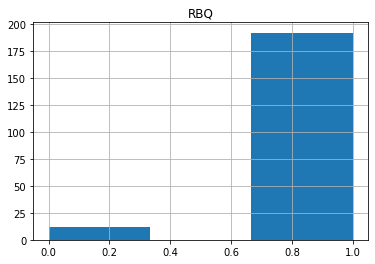

In [21]:
# Grafico RBQ sin PERSISTENCIA PSA
hist = clean_df.hist(column="RBQ", bins=3)

In [22]:
clean_df["RBQ"].value_counts()

1.0    192
0.0     12
Name: RBQ, dtype: int64

Se favorecerá el 'NO' en las predicciones, ya que las clases están muy desbalanceadas.

## Generación de datos de entrenamiento y test
Usamos el 60% para entrenar y 40% para testear. Lo ideal es 70% para entrenar y 30% para testear, pero tenemos muy pocos datos para testear.

In [23]:
y = clean_df['RBQ'] 
X = clean_df.drop('RBQ', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

## Random Forest

### Búsqueda del mejor valor de n_estimators
Buscamos el mejor `n_estimators` (número de árboles del Random Forest). Se ha elegido un rango entre 2 (un Random Forest tiene al menos dos árboles) y 100. Se podría haber puesto un rango máximo mayor, pero eso haría que la ejecución de la celda siguiente tarde más.

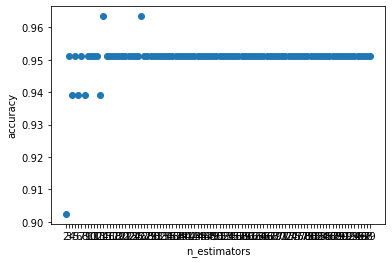

In [24]:
def get_best_n_estimators():
    y = clean_df['RBQ'] 
    X = clean_df.drop('RBQ', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
    
    n_estimators_range = range(2, 100)
    scores = []

    for n in n_estimators_range:
        rfc = RandomForestClassifier(n_estimators=n, bootstrap=True, max_samples=100, class_weight='balanced')
                    
        rfc.fit(X_train, y_train)

        scores.append(rfc.score(X_test, y_test))

    plt.figure()
    plt.xlabel('n_estimators')
    plt.ylabel('accuracy')
    plt.scatter(n_estimators_range, scores)
    plt.xticks(n_estimators_range)

get_best_n_estimators()

Ejecutando la celda anterior, se puede observar que la precisión es de aproximadamente 0.9 para cualquier valor de `n_estimators`, por lo que se puede seleccionar cualquier valor. La teoría recomienda usar la mayor cantidad de estimadores posible, pero en este caso se utilizarán 100.

### Búsqueda del mejor valor de ```max_samples```

Buscamos el mejor ```max_samples``` (número de pacientes por árbol). Se ha elegido un rango entre 100 y 122 ya que para el entrenamiento solo disponemos de 122 filas. Si ```max_samples=122```, todos los árboles serían iguales y el random forest no sería tan efectivo. Si ```max_samples``` es muy pequeño, no tendríamos los suficientes datos para hacer un buen entrenamiento.

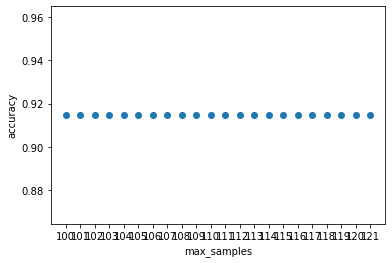

In [25]:
def get_best_max_samples():
    y = clean_df['RBQ'] 
    X = clean_df.drop('RBQ', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
    
    samples_range = range(100, 122)
    scores = []

    for n in samples_range:
        rfc = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=n, class_weight='balanced')
                    
        rfc.fit(X_train, y_train)

        scores.append(rfc.score(X_test, y_test))

    plt.figure()
    plt.xlabel('max_samples')
    plt.ylabel('accuracy')
    plt.scatter(samples_range, scores)
    plt.xticks(samples_range)

get_best_max_samples()

Se ha ejecutado la celda anterior varias veces. La tendencia es que el accuracy sea de aproximadamente 0.9 en la mayoría de casos, por lo que podemos escoger cualquier valor entre 100 y 122. En algunas ejecuciones hay valores de ```max_samples``` que producen un mayor accuracy, pero eso no siempre es así. Podemos seleccionar cualquier valor de ```max_samples```.

### Entrenamiento y valoración del modelo con Random Forest

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.95      1.00      0.97        78

    accuracy                           0.95        82
   macro avg       0.48      0.50      0.49        82
weighted avg       0.90      0.95      0.93        82

Score: 0.9512195121951219


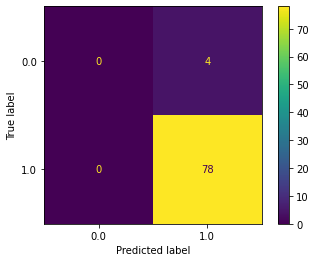

In [26]:
y = clean_df['RBQ'] 
X = clean_df.drop('RBQ', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

# n_estimators = 100. cuanto más filas haya, mas estimadores tiene que haber.
# Bootstrap = True. Utilizamos "trocitos" del data set para construir cada árbol
# max_samples = 100. Generamos aleatoriamente árboles de 100 pacientes cada uno
# class_weight='balanced'. Balancemos las clases

# Resumen: Generamos 100 árboles de decisión con 50 pacientes cada uno.
rfc = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=100, class_weight='balanced')
                    
rfc.fit(X_train, y_train)

plot_confusion_matrix(rfc, X_test, y_test)
print(classification_report(y_test, rfc.predict(X_test), zero_division=0))
print('Score: ' + str(rfc.score(X_test, y_test)))

### Curva ROC y AUC de Random Forest

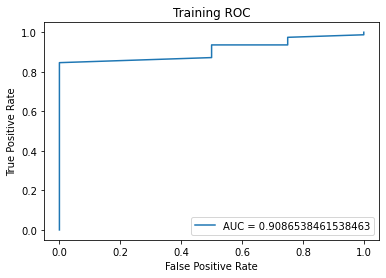

In [27]:
y_predict_proba = rfc.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
auc = roc_auc_score(y_test, y_predict_proba)

plt.plot(fpr,tpr, label='AUC = ' + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('Training ROC')
plt.show()

## KNN

### Búsqueda del mejor valor de K para KNN

Buscamos el mejor valor de K, utilizando dos distancias: Manhattan(1) y Euclídea(2)

In [28]:
def get_best_k_using_distance(distance):
    y = clean_df['RBQ'] 
    X = clean_df.drop('RBQ', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

    k_range = range(1, 10)
    scores = []

    for k in k_range:
        pipe_knn = Pipeline([
                         ('norm', MinMaxScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=k, p=distance))    
                        ])

        pipe_knn.fit(X_train, y_train)

        scores.append(pipe_knn.score(X_test, y_test))

    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks(k_range)

### Selección de K con normalización y distancia Manhattan

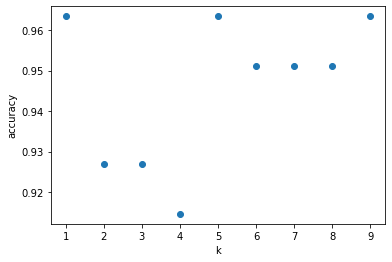

In [29]:
get_best_k_using_distance(1)

### Selección de K con normalización y distancia Euclídea

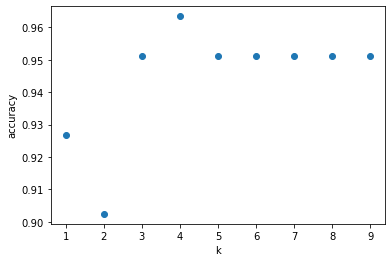

In [30]:
get_best_k_using_distance(2)

Tras varias ejecuciones a mano de las dos funciones anteriores, se ha observado que el accuracy suele ser más o menos similar. Es cierto que en algunas ejecuciones se pueden encontrar algunos picos, pero esos accuracy no son siempre así, y usar pocos vecinos haría que nuestras predicciones no sean correctas, produciendo overfitting. La distancia euclídea parece que ofrece mayor accuracy.

### Entrenamiento y valoración del modelo con KNN

KNN requiere de escalado para funcionar correctamente. Además, estas predicciones están basadas en distancias, por lo que escalar todas las variables a valores entre 0 y 1 puede ser buena idea, ya que las variables de nuestro dataset tienen distintos rangos.

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.94      1.00      0.97        58

    accuracy                           0.94        62
   macro avg       0.47      0.50      0.48        62
weighted avg       0.88      0.94      0.90        62

Score: 0.9354838709677419


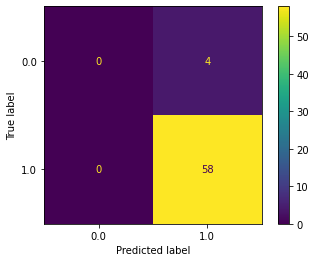

In [31]:
y = clean_df['RBQ'] 
X = clean_df.drop('RBQ', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# n_neighbors=10. El cluster al que pertenece el nuevo paciente depende de los 10 vecinos más cercanos.
# p = 2. Utilizamos la distancia euclídea.
pipe_knn = Pipeline([
                     ('norm', MinMaxScaler()),
                     ('knn', KNeighborsClassifier(n_neighbors=3, p=2))    
                    ])


pipe_knn.fit(X_train, y_train)

plot_confusion_matrix(pipe_knn, X_test, y_test)
print(classification_report(y_test, pipe_knn.predict(X_test), zero_division=0))
print('Score: ' + str(pipe_knn.score(X_test, y_test)))

### Curva ROC y AUC de kNN

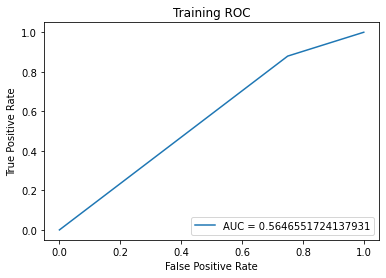

In [32]:
y_predict_proba = pipe_knn.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
auc = roc_auc_score(y_test, y_predict_proba)

plt.plot(fpr,tpr, label='AUC = ' + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('Training ROC')
plt.show()

## Regresión Logística

### Selección de ```C``` para Regresión Logística

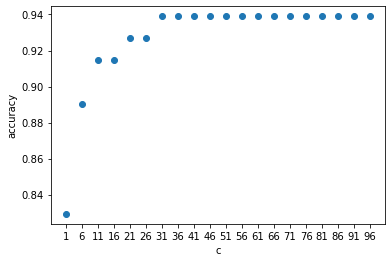

In [33]:
def get_best_c():
    y = clean_df['RBQ'] 
    X = clean_df.drop('RBQ', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
    
    # El rango es en realidad de 0 a 1, pero range() no permite floats. Posteriormente se pasa como parametro c/100.
    c_range = range(1, 100, 5)
    scores = []

    for c in c_range:
        pipe_clr = Pipeline([
                     ('scl', StandardScaler()),
                     ('clr', LogisticRegression(C=c/100, penalty='l2', solver='liblinear', class_weight='balanced'))    
                    ])

        pipe_clr.fit(X_train, y_train)

        scores.append(pipe_clr.score(X_test, y_test))

    plt.figure()
    plt.xlabel('c')
    plt.ylabel('accuracy')
    plt.scatter(c_range, scores)
    plt.xticks(c_range)

get_best_c()

Se han realizado varias iteraciones para ver cuál es el mejor valor de ```C```, y se ha observado que se obtiene mayor accuracy con valores ```C > 0.4```

### Entrenamiento y valoración del modelo con Regresión Logística

              precision    recall  f1-score   support

         0.0       0.14      0.50      0.22         2
         1.0       0.98      0.90      0.94        60

    accuracy                           0.89        62
   macro avg       0.56      0.70      0.58        62
weighted avg       0.95      0.89      0.92        62

Score: 0.8870967741935484


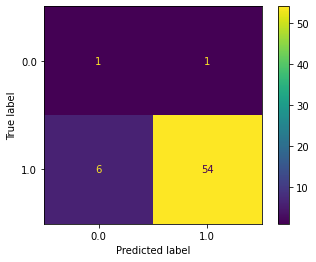

In [34]:
y = clean_df['RBQ'] 
X = clean_df.drop('RBQ', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# solver ='liblinear'. Es el recomendado para datasets pequeños.
# class_weight='balanced'. Balancemos las clases
pipe_clr = Pipeline([
                     ('scl', StandardScaler()),
                     ('clr', LogisticRegression(C=0.5, penalty='l2', solver='liblinear', class_weight='balanced'))    
                    ])

pipe_clr.fit(X_train, y_train)

plot_confusion_matrix(pipe_clr, X_test, y_test)
print(classification_report(y_test, pipe_clr.predict(X_test), zero_division=0))
print('Score: ' + str(pipe_clr.score(X_test, y_test)))

### Curva ROC y AUC de Regresión Logística

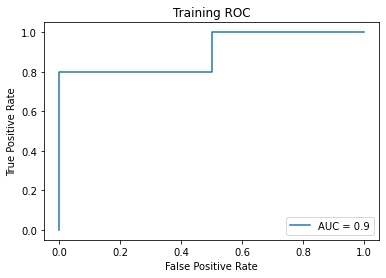

In [35]:
y_predict_proba = pipe_clr.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
auc = roc_auc_score(y_test, y_predict_proba)

plt.plot(fpr,tpr, label='AUC = ' + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('Training ROC')
plt.show()

## Voting Classifier

Se ha utilizado un Voting Classifier para seleccionar el mejor modelo entre los tres entrenados anteriormente.

              precision    recall  f1-score   support

         0.0       0.50      0.25      0.33         4
         1.0       0.95      0.98      0.97        58

    accuracy                           0.94        62
   macro avg       0.72      0.62      0.65        62
weighted avg       0.92      0.94      0.93        62

Score: 0.9354838709677419


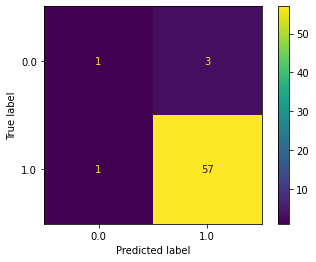

In [36]:
y = clean_df['RBQ'] 
X = clean_df.drop('RBQ', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# solver ='liblinear'. Es el recomendado para datasets pequeños.
# class_weight='balanced'. Balancemos las clases
voting = VotingClassifier(
                    estimators=[('prfc', rfc),('pknn', pipe_knn), ('plrc', pipe_clr)],
                    voting='soft'
                )

voting.fit(X_train, y_train)

plot_confusion_matrix(voting, X_test, y_test)
print(classification_report(y_test, voting.predict(X_test), zero_division=0))
print('Score: ' + str(voting.score(X_test, y_test)))

### Curva ROC y AUC de Voting Classifier

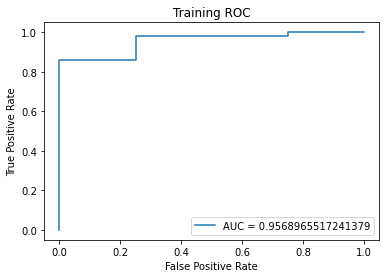

In [37]:
y_predict_proba = pipe_clr.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
auc = roc_auc_score(y_test, y_predict_proba)

plt.plot(fpr,tpr, label='AUC = ' + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('Training ROC')
plt.show()

# Bibliografía
- Estimadores: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

- Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Regresión Logística: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html